## Libraries

In [66]:
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
import numpy as np
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Set random seed to the answer to the universe

tf.random.set_seed(42)
IMG_SIZE = 128
BATCH_SIZE = 32


## Data Preprocessing

In [67]:
def scale_normalize(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, tf.one_hot(label, depth=8)

def gaussian_noise(image, label):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=abs(np.random.normal(loc=0.0, scale=0.1)),dtype=tf.float32)
    image = tf.add(image, noise)
    return image, label

In [68]:
ds_train, ds_test = tfds.load('colorectal_histology', split=['train[:70%]', 'train[70%:]'],
              shuffle_files=True, as_supervised=True)

ds_train = ds_train.map(scale_normalize)
ds_train = ds_train.cache()
ds_train = ds_train.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
ds_train = ds_train.map(lambda image, label: (tf.image.random_flip_up_down(image), label))
ds_train = ds_train.map(gaussian_noise)
ds_train = ds_train.shuffle(1000)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.repeat(4)

ds_test = ds_test.map(scale_normalize).batch(BATCH_SIZE)

ds_train_autoencoder = ds_train.map(lambda image, label: (image, image))
ds_test_autoencoder = ds_test.map(lambda image, label: (image, image))


print("[TRAIN]: ", ds_train)
print("[TEST]: ", ds_test)


[TRAIN]:  <RepeatDataset shapes: ((None, 128, 128, 3), (None, 8)), types: (tf.float32, tf.float32)>
[TEST]:  <BatchDataset shapes: ((None, 128, 128, 3), (None, 8)), types: (tf.float32, tf.float32)>


## Autoencoder

In [ ]:
def autoencoder_model(input_shape=(128, 128, 3), kernel_size=(3,3), pool_size=(2,2)):
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(128, kernel_size, activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size, padding='same')(x)
    x = layers.Conv2D(64, kernel_size, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size, padding='same')(x)
    x = layers.Conv2D(32, kernel_size, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    encoded = layers.MaxPooling2D(pool_size, padding='same', name='encoder')(x)

    x = layers.Conv2D(32, kernel_size, activation='relu', padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, kernel_size, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoded = layers.Conv2D(input_shape[2], kernel_size, activation='sigmoid', padding='same')(x)

    autoencoder = k.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['acc'])

    return autoencoder



In [ ]:
autoencoder = autoencoder_model()

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0     

In [ ]:
autoencoder.fit(ds_train_autoencoder,
                epochs=25,
                validation_data=ds_test_autoencoder, 
                callbacks=[
                           k.callbacks.TensorBoard(log_dir="./autoencoder/logs"), 
                           k.callbacks.ModelCheckpoint('./autoencoder/ckpt/autoencoder-{epoch:02d}-{val_loss:.4f}.hdf5', 
                                                       monitor='val_loss', 
                                                       save_best_only=False, 
                                                       save_freq='epoch')
                           ]
                )

Epoch 1/25
440/440 [==============================] - 147s 255ms/step - loss: 0.0309 - acc: 0.5450 - val_loss: 0.0187 - val_acc: 0.6578
Epoch 2/25
440/440 [==============================] - 108s 242ms/step - loss: 0.0182 - acc: 0.5864 - val_loss: 0.0072 - val_acc: 0.6688
Epoch 3/25
440/440 [==============================] - 108s 243ms/step - loss: 0.0166 - acc: 0.5897 - val_loss: 0.0072 - val_acc: 0.6983
Epoch 4/25
440/440 [==============================] - 108s 242ms/step - loss: 0.0161 - acc: 0.5944 - val_loss: 0.0045 - val_acc: 0.6971
Epoch 5/25
440/440 [==============================] - 108s 242ms/step - loss: 0.0159 - acc: 0.5932 - val_loss: 0.0056 - val_acc: 0.7142
Epoch 6/25
440/440 [==============================] - 108s 241ms/step - loss: 0.0155 - acc: 0.5962 - val_loss: 0.0063 - val_acc: 0.7119
Epoch 7/25
440/440 [==============================] - 109s 244ms/step - loss: 0.0152 - acc: 0.5965 - val_loss: 0.0075 - val_acc: 0.7009
Epoch 8/25
440/440 [============================

In [ ]:
autoencoder.evaluate(ds_test_autoencoder)

47/47 [==============================] - 4s 78ms/step - loss: 0.0035 - acc: 0.7458


[0.003536514937877655, 0.745845377445221]

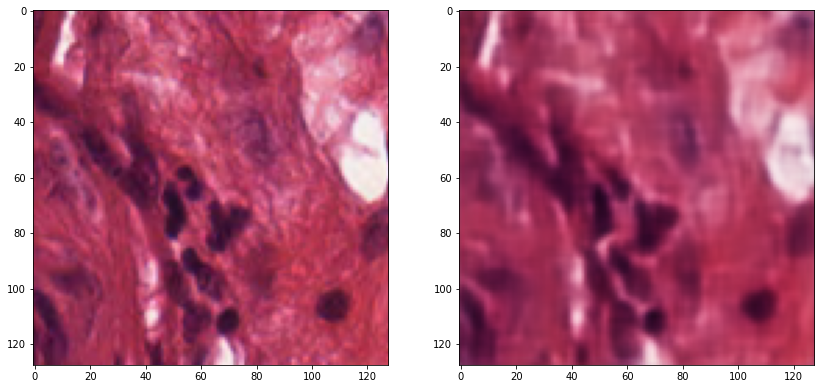

In [94]:
autoencoder = k.models.load_model('./autoencoder/ckpt/autoencoder-24-0.0029.hdf5')
n = np.random.randint(0,32)
item = ds_test_autoencoder.take(1)
imgs = None

for image, label in tfds.as_numpy(item):
    imgs = image
    break

predict = autoencoder.predict(item)
# print(item.shape, predict.shape)

fig, axs = plt.subplots(1,2, figsize=(14,16))
axs[0].imshow(imgs[n])
axs[1].imshow(predict[n])

# plt.show()

## Model fijado


In [ ]:

def model(encoder, trainable=False):
    encoder.trainable = trainable

    model = k.Sequential([
        encoder,
        layers.Flatten(),
        layers.Dense(4096, activation="relu"),
        layers.Dense(4096, activation="relu"),
        layers.Dense(2042, activation="relu"),
        layers.Dense(2042, activation="relu"),
        layers.Dense(1024, activation="relu"),
        layers.Dense(1024, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(8, activation='softmax')
    ])
    model.compile(optimizer='SGD', loss='mse', metrics=['acc', 'categorical_accuracy'])
    return model



In [ ]:

# Obtain features from middle layer
autoencoder = k.models.load_model('./autoencoder/ckpt/autoencoder-24-0.0029.hdf5')

encoder = k.Model(inputs=autoencoder.input,
                  outputs=autoencoder.get_layer('encoder').output)

encoder.summary()

classifier_fixed = model(encoder)

classifier_fixed.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0   

In [ ]:
classifier_fixed.fit(ds_train,
                epochs=25,
                validation_data=ds_test, 
                callbacks=[
                           k.callbacks.TensorBoard(log_dir="./classifier-fixed/logs"), 
                           k.callbacks.ModelCheckpoint('./classifier-fixed/ckpt/classifier-fixed-{epoch:02d}-{val_loss:.4f}.hdf5', 
                                                       monitor='val_loss', 
                                                       save_best_only=False, 
                                                       save_freq='epoch')
                           ]
                )

Epoch 1/25
440/440 [==============================] - 49s 105ms/step - loss: 0.1023 - acc: 0.3436 - categorical_accuracy: 0.3436 - val_loss: 0.0780 - val_acc: 0.5920 - val_categorical_accuracy: 0.5920
Epoch 2/25
440/440 [==============================] - 46s 100ms/step - loss: 0.0664 - acc: 0.6573 - categorical_accuracy: 0.6573 - val_loss: 0.0540 - val_acc: 0.7060 - val_categorical_accuracy: 0.7060
Epoch 3/25
440/440 [==============================] - 45s 99ms/step - loss: 0.0460 - acc: 0.7572 - categorical_accuracy: 0.7572 - val_loss: 0.0579 - val_acc: 0.6680 - val_categorical_accuracy: 0.6680
Epoch 4/25
440/440 [==============================] - 46s 101ms/step - loss: 0.0387 - acc: 0.7974 - categorical_accuracy: 0.7974 - val_loss: 0.0478 - val_acc: 0.7207 - val_categorical_accuracy: 0.7207
Epoch 5/25
440/440 [==============================] - 46s 102ms/step - loss: 0.0337 - acc: 0.8264 - categorical_accuracy: 0.8264 - val_loss: 0.0472 - val_acc: 0.7273 - val_categorical_accuracy: 0.7

In [ ]:
classifier_fixed.evaluate(ds_test)

47/47 [==============================] - 2s 45ms/step - loss: 0.0443 - acc: 0.7573 - categorical_accuracy: 0.7573


[0.04430024325847626, 0.7573333382606506, 0.7573333382606506]

## Model sin fijar

In [ ]:
# Obtain features from middle layer
autoencoder = k.models.load_model('./autoencoder/ckpt/autoencoder-24-0.0029.hdf5')

encoder = k.Model(inputs=autoencoder.input,
                  outputs=autoencoder.get_layer('encoder').output)

encoder.summary()

classifier_trainable = model(encoder, trainable=True)

classifier_trainable.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0   

In [ ]:
classifier_trainable.fit(ds_train,
                epochs=25,
                validation_data=ds_test, 
                callbacks=[
                           k.callbacks.TensorBoard(log_dir="./classifier-trainable/logs"), 
                           k.callbacks.ModelCheckpoint('./classifier-trainable/ckpt/classifier-trainable-{epoch:02d}-{val_loss:.4f}.hdf5', 
                                                       monitor='val_loss', 
                                                       save_best_only=False, 
                                                       save_freq='epoch')
                           ]
                )

Epoch 1/25
440/440 [==============================] - 70s 153ms/step - loss: 0.1016 - acc: 0.2749 - categorical_accuracy: 0.2749 - val_loss: 0.0774 - val_acc: 0.5660 - val_categorical_accuracy: 0.5660
Epoch 2/25
440/440 [==============================] - 70s 154ms/step - loss: 0.0679 - acc: 0.6353 - categorical_accuracy: 0.6353 - val_loss: 0.0629 - val_acc: 0.6347 - val_categorical_accuracy: 0.6347
Epoch 3/25
440/440 [==============================] - 70s 156ms/step - loss: 0.0499 - acc: 0.7313 - categorical_accuracy: 0.7313 - val_loss: 0.0635 - val_acc: 0.6333 - val_categorical_accuracy: 0.6333
Epoch 4/25
440/440 [==============================] - 69s 153ms/step - loss: 0.0432 - acc: 0.7642 - categorical_accuracy: 0.7642 - val_loss: 0.0577 - val_acc: 0.6740 - val_categorical_accuracy: 0.6740
Epoch 5/25
440/440 [==============================] - 70s 155ms/step - loss: 0.0392 - acc: 0.7851 - categorical_accuracy: 0.7851 - val_loss: 0.0560 - val_acc: 0.6713 - val_categorical_accuracy: 0.

In [ ]:
classifier_trainable.evaluate(ds_test)

47/47 [==============================] - 2s 43ms/step - loss: 0.0683 - acc: 0.6553 - categorical_accuracy: 0.6553


[0.06830702722072601, 0.6553333401679993, 0.6553333401679993]

In [ ]:
def full_model(input_shape=(128, 128, 3), kernel_size=(3,3), pool_size=(2,2)):
    model = k.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(128, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size, padding='same'),
        layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size, padding='same'),
        layers.Conv2D(32, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size, padding='same', name='encoder'),

        layers.Flatten(),
        layers.Dense(4096, activation="relu"),
        layers.Dense(4096, activation="relu"),
        layers.Dense(2042, activation="relu"),
        layers.Dense(2042, activation="relu"),
        layers.Dense(1024, activation="relu"),
        layers.Dense(1024, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(8, activation='softmax')
    ])

    lr_schedule = k.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = k.optimizers.SGD(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='mse', metrics=['acc', 'categorical_accuracy'])
    return model


In [ ]:
full_model = full_model()

full_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization_27 (Batc (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 64)        73792     
_________________________________________________________________
batch_normalization_28 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 32)      

In [ ]:
full_model.fit(ds_train,
                epochs=25,
                validation_data=ds_test, 
                callbacks=[
                           k.callbacks.TensorBoard(log_dir="./full-model/logs"), 
                           k.callbacks.ModelCheckpoint('./full-model/ckpt/full-model-{epoch:02d}-{val_loss:.4f}.hdf5', 
                                                       monitor='val_loss', 
                                                       save_best_only=False, 
                                                       save_freq='epoch')
                           ]
                )

Epoch 1/25
440/440 [==============================] - 72s 158ms/step - loss: 0.0997 - acc: 0.2677 - categorical_accuracy: 0.2677 - val_loss: 0.1052 - val_acc: 0.2113 - val_categorical_accuracy: 0.2113
Epoch 2/25
440/440 [==============================] - 70s 155ms/step - loss: 0.0713 - acc: 0.6105 - categorical_accuracy: 0.6105 - val_loss: 0.0849 - val_acc: 0.4440 - val_categorical_accuracy: 0.4440
Epoch 3/25
440/440 [==============================] - 70s 155ms/step - loss: 0.0524 - acc: 0.7123 - categorical_accuracy: 0.7123 - val_loss: 0.0843 - val_acc: 0.4773 - val_categorical_accuracy: 0.4773
Epoch 4/25
440/440 [==============================] - 70s 154ms/step - loss: 0.0432 - acc: 0.7604 - categorical_accuracy: 0.7604 - val_loss: 0.0879 - val_acc: 0.4507 - val_categorical_accuracy: 0.4507
Epoch 5/25
440/440 [==============================] - 69s 154ms/step - loss: 0.0387 - acc: 0.7886 - categorical_accuracy: 0.7886 - val_loss: 0.0741 - val_acc: 0.5833 - val_categorical_accuracy: 0.

In [ ]:
full_model.evaluate(ds_test)

47/47 [==============================] - 2s 46ms/step - loss: 0.2203 - acc: 0.1187 - categorical_accuracy: 0.1187


[0.22033333778381348, 0.11866666376590729, 0.11866666376590729]